## Classification of Heart Disease Diagnosis

## Introduction

The processed Cleveland Data contains patient information including age and blood pressure. These attributes will be used to predict whether a patients has heart disease. In this proposal, we'll use machine learning to analyze the dataset and develop a predictive models for heart disease diagnosis. The goal of this is to provide a tool to healthcare professionals to assist in early detection of heart disease. 

The question this model will try to answer is: can we accurately predict the presence of heart disease based on demographic and clinical attributes using the provided dataset. 

The data set containts information on 303 patients with 13 features about each one. The presence of heart disease is shown with integers ranging from 0 (no heart disease) to 4.

## Preliminary exploratory data analysis

In [67]:
library(tidyverse)
library(repr)
library(tidymodels)
library(gridExtra)
options(repr.matrix.max.rows = 6)

variable_names <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")
cleve_data <- read.table("data/processed.cleveland.data", header = TRUE, sep = ",", col.names = variable_names)
print("Table 1: Cleveland Dataset")
cleve_data

[1] "Table 1: Cleveland Dataset"


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


The above is our inital datatset read from the web. We are using the processed cleveland dataset as it has already been preprocessed into a tidy form.

Next we are able to select columns we wish to be our predictors. In this case, chose to include age, sex, resting blood pressure, serum cholestoral, and maximum heart rate achieved as our predictor variables as these are crucial variables when it comes to determining if a patient has hard disease or not.

Below, we have selected our predictor variables from the dataset and mutated our nums predictor to a factor.

In [68]:
cleve_data <- cleve_data |>
    select(age, sex, trestbps, chol, thalach, num) |>
    mutate(num = as_factor(num))

print("Table 2: Adjusted Cleveland Dataset")
cleve_data

[1] "Table 2: Adjusted Cleveland Dataset"


age,sex,trestbps,chol,thalach,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
67,1,160,286,108,2
67,1,120,229,129,1
37,1,130,250,187,0
⋮,⋮,⋮,⋮,⋮,⋮
57,1,130,131,115,3
57,0,130,236,174,1
38,1,138,175,173,0


We then split our data into 75% training and 25% testing. 

In [69]:
set.seed(1)

cleve_split <- initial_split(cleve_data, prop = 0.75, strata = num)
cleve_train <- training(cleve_split)
cleve_test <- testing(cleve_split)

cat("Table 3: Training Set Data")
cleve_train
print("Table 4: Testing Set Data")
cleve_test

Table 3: Training Set Data

age,sex,trestbps,chol,thalach,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
37,1,130,250,187,0
56,1,120,236,178,0
44,1,120,263,173,0
⋮,⋮,⋮,⋮,⋮,⋮
55,0,128,205,130,3
59,1,164,176,90,3
57,1,130,131,115,3


[1] "Table 4: Testing Set Data"


age,sex,trestbps,chol,thalach,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
41,0,130,204,172,0
57,0,120,354,163,0
57,1,140,192,148,0
⋮,⋮,⋮,⋮,⋮,⋮
58,1,114,318,140,4
68,1,144,193,141,2
57,0,130,236,174,1


### Training Data Summary Table

Below is a table containing summary information regarding the number of observations in each class and the means of the predictor variables we selected from above. There are no missing values in any of these columns as stated in the dataset database.

In [70]:
cleve_train_summary <- cleve_train |>
    group_by(num) |>
    summarise(across(where(is.numeric), mean, na.rm = TRUE),  
              n = n())

print("Table 5: Training Set Data Summary")
cleve_train_summary

[1] "Table 5: Training Set Data Summary"


num,age,sex,trestbps,chol,thalach,n
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,52.00813,0.6097561,127.8130,240.2114,159.2358,123
1,55.68293,0.8292683,133.4878,248.7561,144.3171,41
2,57.56000,0.8400000,133.9200,265.0000,132.8000,25
3,55.15385,0.8846154,132.5769,241.7308,133.6538,26
4,58.50000,0.9000000,139.5000,239.5000,140.9000,10


### Training Data Visualization

We create a histogram using our training data to display the distribution of all our predictor variables. This lets us visualize our data and make sure our variables make sense. 

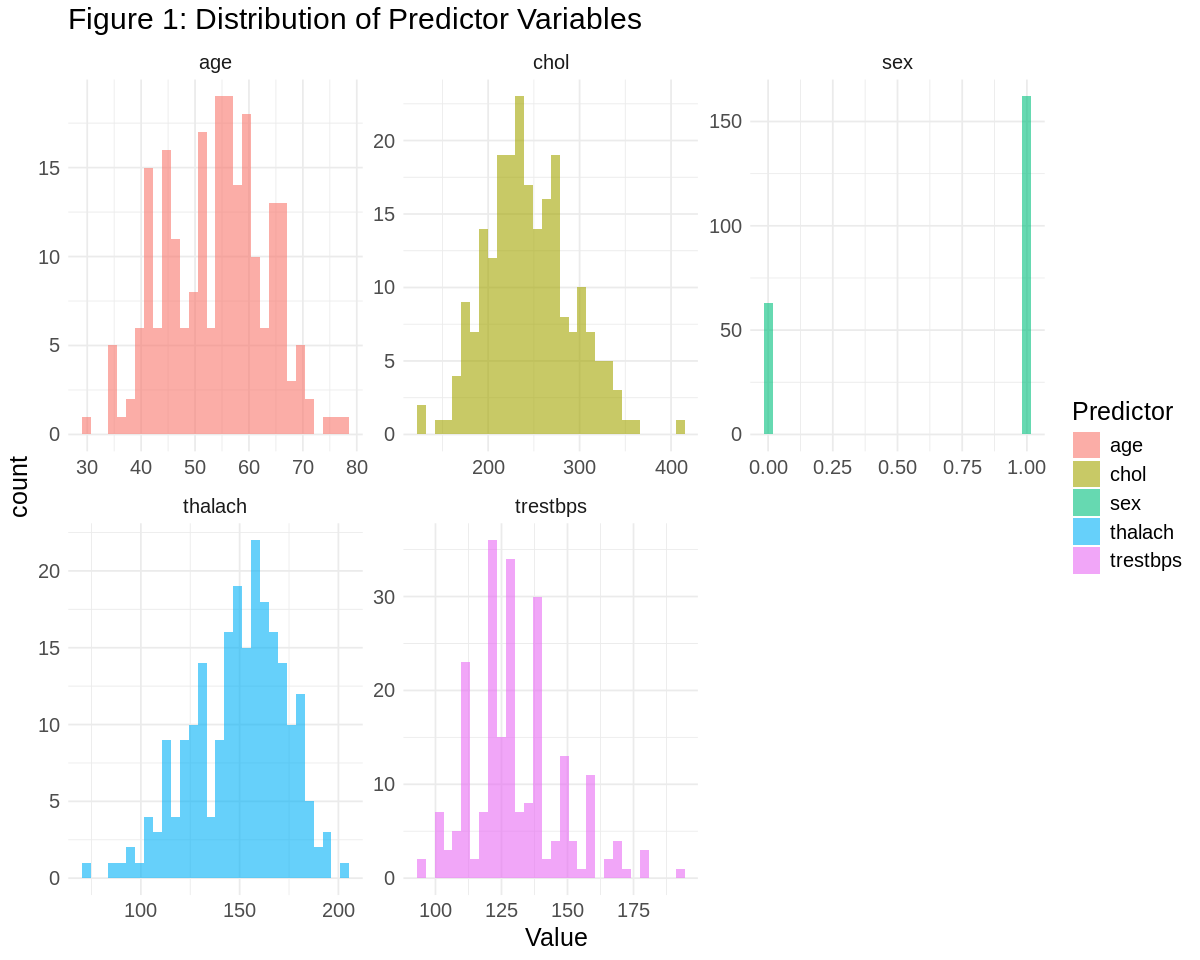

In [71]:
options(repr.plot.width = 10, repr.plot.height = 8)

predictor_variables <- c("age", "sex", "trestbps", "chol", "thalach")

data_long <- pivot_longer(cleve_train, 
                          cols = predictor_variables, 
                          names_to = "Predictor", 
                          values_to = "Value")

plot <- ggplot(data_long, aes(x = Value, fill = Predictor)) +
    geom_histogram(bins = 30, alpha = 0.6, position = "identity") +
    facet_wrap(~ Predictor, scales = "free") +
    theme_minimal() +
    labs(title = "Figure 1: Distribution of Predictor Variables") +
    theme(text = element_text(size = 15)) 

plot

## Methods


We will use KNN to classify whether a patient has heart disease. The variable we are looking to predict is represented by the num column. 

First, we will put the variables we wish to use as predictors into a **recipe** and both **scale** and **center** them. 

Next, we will create a **model specification** that will tune for the best k value. 

After, we will perform a **5-fold cross-validation** on the training set and create a **workflow** that includes our recipe and model specification. We will try all integer k-values from 2 - 10 and plot the results to determine the most accurate k-value.

Finally, we will create our model by adding both a new **model specification** that will use straight line distance and found k and the recipe we made before to a new **workflow**. We will use this model to **predict** the values in our testing set. We will also check our model's **accuracy**, **precision**, and **recall** using **metrics** and the **confusion matrix**.

We will visualize these results by using scatterplots to compare two variables against the class we are predicting (represented by colour) and then plot the test observations to see whether our model has correctly predicted the class of heart disease.

#### Recipe
First, we make a recipe with the predictors we wish to use. We select all predictors using num ~ . from our training data, cleve_train. Then we scale, center, and prep those variables.

In [79]:
#Recipe
cleve_recipe <- recipe(num ~ ., data = cleve_train) |>
                step_scale(predictor_variables) |>
                step_center(predictor_variables) |>
                prep()

#### Model Specification
After, as seen below, we specify the model for tuning to find the best k-values to use for classification.

In [73]:
#Model Specification
cleve_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                set_engine("kknn") |>
                set_mode("classification")

#### Cross Validation and Workflow
After, we will perform a 5-fold cross-validation on the training set by creating a workflow that includes our recipe and model specification. We will try all integer k-values from 2 - 10, collect the metrics and filter for accuracy, and then finally plot the results to determine the most accurate k-value.

In [80]:
#cross val
folds <- vfold_cv(cleve_train, v = 5, strata = num)

→ A | warning: No observations were detected in `truth` for level(s): '4'
               Computation will proceed by ignoring those levels.

There were issues with some computations   A: x1

There were issues with some computations   A: x2





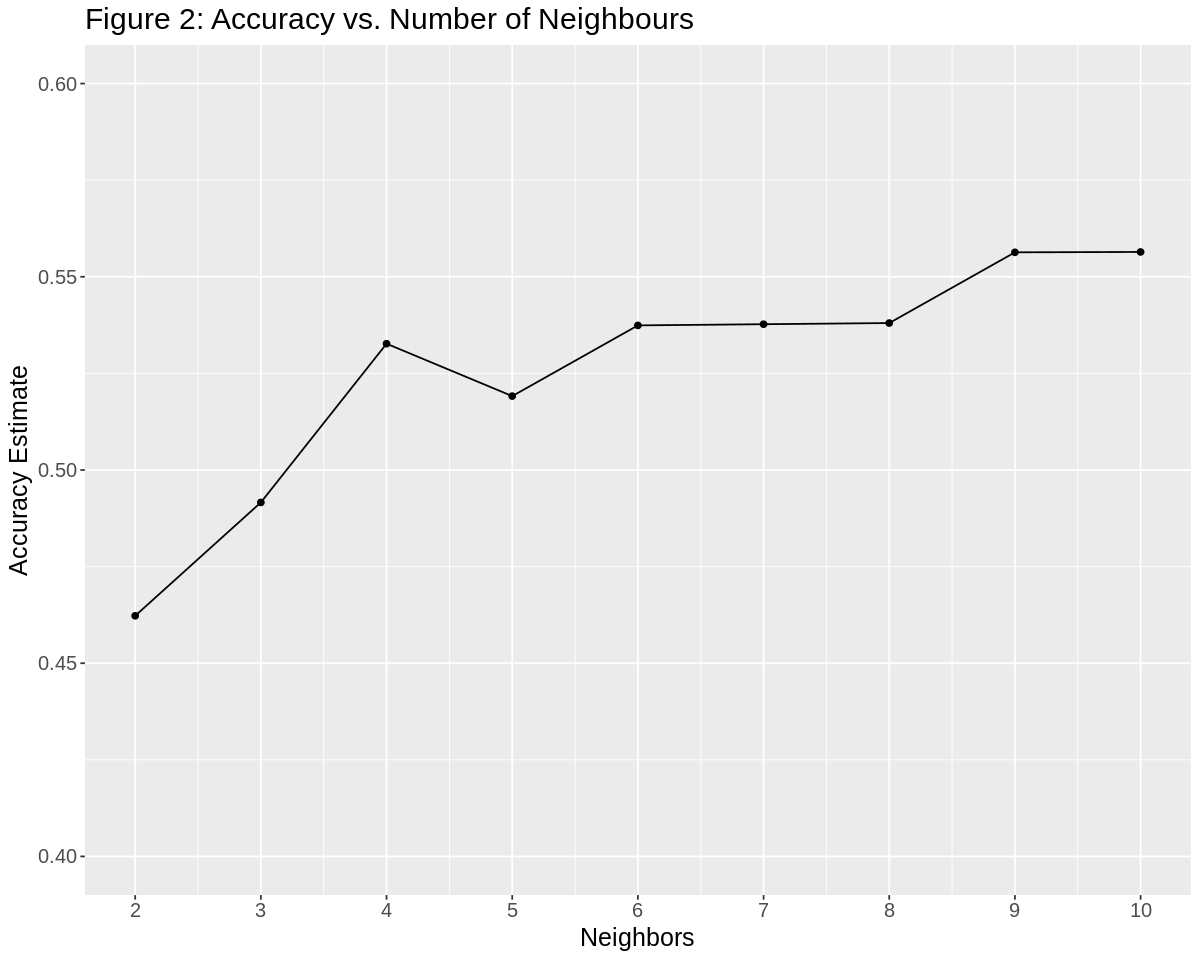

In [75]:
options(repr.plot.width = 10, repr.plot.height = 8)

#workflow
k_vals <- tibble(neighbors = seq(from = 2, to = 10))

results <- workflow() |>
    add_recipe(cleve_recipe) |>
    add_model(cleve_spec) |>
    tune_grid(resamples = folds, grid = k_vals)

#metrics
metrics <- collect_metrics(results)

accuracies <- metrics |> 
    filter(.metric == "accuracy")

#plot
cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", 
         y = "Accuracy Estimate", 
         title = "Figure 2: Accuracy vs. Number of Neighbours") +
    scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
    scale_y_continuous(limits = c(0.4, 0.6)) + # adjusting the y-axis
    theme(text = element_text(size = 15))
    
cross_val_plot

#### Prediction Model
From our cross validation plot, we will choose k=4 as all further k past 4 does not increase our accuracy by a significant amount. Using this information, we can create a new model specification with neighbours = 4 and add it to a new workflow with the old recipe and train it using our training data. 

In [76]:
#new model 
cleve_final_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 4) |>
                set_engine("kknn") |>
                set_mode("classification")

cleve_final_fit <- workflow() |>
             add_recipe(cleve_recipe) |>
             add_model(cleve_final_spec) |>
             fit(data = cleve_train)

Once we finish training our model, we can try predicting the values in our test set. We will also checked our model's accuracy, precision, and recall using metrics and the confusion matrix.

In [77]:
#Testing

cleve_predictions <- predict(cleve_final_fit, cleve_test) |>
            bind_cols(cleve_test |> select(num))
print("Table 6: Prediction and Target Values")
cleve_predictions

cleve_metrics <- cleve_predictions |>
                  metrics(truth = num, estimate = .pred_class)
print("Table 7: Test Data Prediction Metrics")
cleve_metrics

cleve_conf_mat <- cleve_predictions |>
                  conf_mat(truth = num, estimate = .pred_class)
print("Figure 3: Confusion Matrix")
cleve_conf_mat

[1] "Table 6: Prediction and Target Values"


.pred_class,num
<fct>,<fct>
0,0
0,0
1,0
⋮,⋮
0,4
1,2
0,1


[1] "Table 7: Test Data Prediction Metrics"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.4935065
kap,multiclass,0.1437126


[1] "Figure 3: Confusion Matrix"


          Truth
Prediction  0  1  2  3  4
         0 35  6  8  3  2
         1  2  2  3  4  0
         2  2  2  0  2  0
         3  1  3  0  0  0
         4  0  1  0  0  1

Finally, for clearer visualization and an easier time analyzing our data, we wil plot our results using scatterplots. We compared two variables against the class we are predicting (represented by colour) and then plotted the test observations to see whether our model has correctly predicted the class of heart disease. 

We will plot age and cholestrol as our x and y variables in the scatterplot just for visualization purposes.

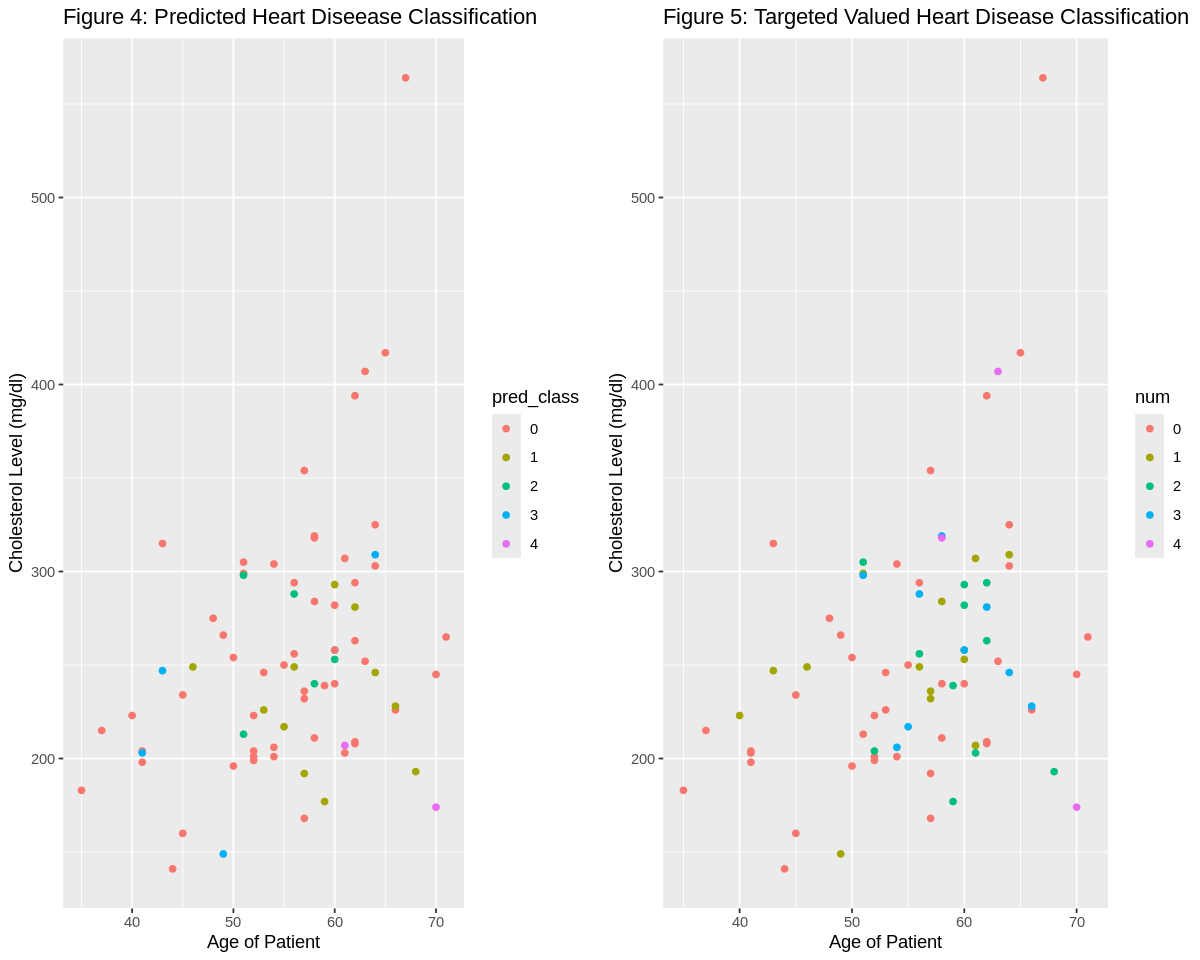

In [78]:
#plot
cleve_test["pred_class"] = cleve_predictions[".pred_class"]

pred_plot <- cleve_test |>
                    ggplot(aes(x = age, y = chol)) +
                    geom_point(aes(color = pred_class)) +
                    labs(x = "Age of Patient", y = "Cholesterol Level (mg/dl)", color = "pred_class") +
                    ggtitle("Figure 4: Predicted Heart Diseease Classification")

num_plot <- cleve_test |>
                    ggplot(aes(x = age, y = chol)) +
                    geom_point(aes(color = num)) +
                    labs(x = "Age of Patient", y = "Cholesterol Level (mg/dl)", color = "num") +
                    ggtitle("Figure 5: Targeted Valued Heart Disease Classification")

grid.arrange(pred_plot, num_plot, nrow = 1)

Here we see that there are significant differences with between our predicted values and our initial num values. This indicates that our model did not do a good job in classifying the degree of heart disease risk for our dataset. 

## Discussion and Results

### Summary

The cross-validation plot revealed that selecting k = 4 yielded the highest accuracy, with no significant improvement observed for values exceeding 4, and a decrease in accuracy for k = 5. Since KNN optimizes predictions by averaging the k neighbors, larger distances cause the model to look at data points that may not be in the same predictive class. In this case, the neighbors in k=5 might be in different density regions, which makes the accuracy go down. 


When we constructed a new model with k = 4 neighbors, the resulting accuracy of 49% indicates poor performance. Furthermore, analysis of the plotted graphs indicates a considerable disparity between predicted and actual values. Both the low accuracy and graphical disparities emphasize the model's ineffectiveness in accurately classifying heart disease risk within the dataset. Consequently, it is recommended not to employ this model for heart disease classification purposes.


### Expectations 

Our expectation for this project was to create a model that can diagnose patients with heart disease accurately despite noisy clinical data. The effective categorization of cardiac disease has significant healthcare ramifications as it may expedite the process of identifying high-risk individuals, advancing our knowledge of cardiovascular disease and the risk factors behind them. Furthermore, the effectiveness of the approach may speed up the screening procedure for sizable patient groups, giving medical staff more time to concentrate on early intervention and treatment planning. 

However, our model did not reach these expectations. Our accuracy of 49% indicates that for every diagnosis our model is doing, it is only right around half of the time. In addition, we care most about recall – making sure that we identify all individuals with a disease (true positives), even if it means some healthy individuals are incorrectly identified as having the disease (false positives). However, the recall of our graph is also quite poor. For category 2 heart disease, our model got 0/11 = 0% recall. For category 1, we got 2/14 = 14%. The only category that our model excels at is category 0. For that, our model has 35/40 = 87.5% accuracy. In other words, while the concept of a machine learning model capable of accurately classifying individuals with heart disease is promising, our current model falls short of this goal.



### Potential Impact

Creating an accurate prediction model from this information has the potential to significantly improve early identification and management of heart disease. Identifying high-risk patients based on their characteristics allows healthcare practitioners to intervene early with preventative measures or focused therapies, thereby lowering the burden of heart disease and improving patient outcomes.

### Limitations and Future Research

<ins>Lifestyle and Environmental variables:</ins>

The dataset excludes data on lifestyle variables (e.g., food, physical activity, smoking) and environmental exposures that are known to increase heart disease risk (Kromhout et al. 897). Integrating these variables may increase model accuracy and give a more comprehensive knowledge of risk factors.

<ins>Genetic and biomarker data:</ins> 

Including genetic information and biomarkers related to heart disease might help enhance the prediction model and uncover subgroups with different risk profiles or treatment responses. For example, looking deeper into genes that are assumed to be associated with heart disease likelihood and testing whether they are clear indicators could be a strong way to further increase the model’s scope and accuracy (Gibbons et al. IV-48)

<ins> Socioeconomic and Demographic Factors:</ins> 

Investigating the influence of socioeconomic status, education level, and other demographic factors on heart disease risk and outcomes might shed light on health inequities and guide targeted treatments for vulnerable groups.


## References

Kromhout, D. et al. "Prevention of coronary heart disease by diet and lifestyle: evidence from prospective cross-cultural, cohort, and intervention studies." Circulation, vol. 105, no. 7, 2002, pp. 893-898. https://doi.org/10.1161/hc0702.103728 

Gibbons, G. et al. "Genetic Markers: Progress and Potential for Cardiovascular Disease." Circulation, vol. 109, no. 2, 2004, pp. IV-47–IV-58. https://doi.org/10.1161/01.CIR.0000133440.86427.26

Janosi, A. et al. "Heart Disease." UCI Machine Learning Repository, 1988. https://doi.org/10.24432/C52P4X.
